In [2]:
from qsppack import nlfa
import numpy as np
from matplotlib import pyplot as plt

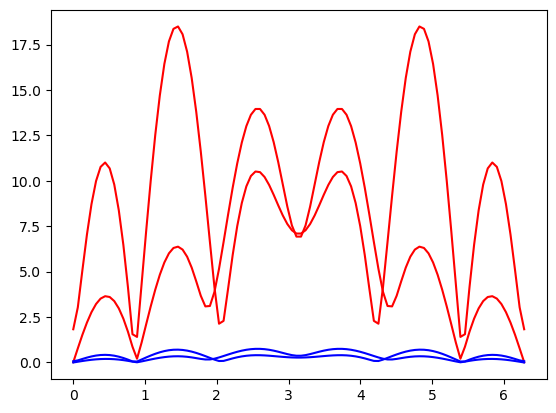

In [30]:
for _ in range(2):
    b = np.random.rand(8) * 10 -5
    bnorm = b / np.sum(np.abs(b))

    thetas = np.linspace(0, 2*np.pi, 100)
    bz = lambda theta: np.dot(b, np.exp(1j* (theta * np.arange(len(b)))))
    bz = np.vectorize(bz)
    bznorm = lambda theta: np.dot(bnorm, np.exp(1j* (theta * np.arange(len(bnorm)))))
    bznorm = np.vectorize(bznorm)

    plt.plot(thetas, np.abs(bz(thetas)), color="r")
    plt.plot(thetas, np.abs(bznorm(thetas)), color="b")
plt.show()

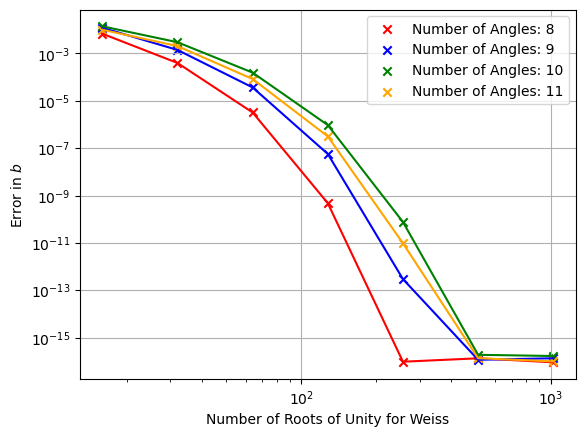

In [58]:
num_angles = np.arange(8,12)
colors = ["red", "blue", "green", "orange"]

for i, num_angle in enumerate(num_angles):
    b = np.random.rand(num_angle)
    b /= (np.sum(np.abs(b)) + 0.1)
    Nvals = 2**np.arange(4, 11)
    errs = np.zeros(len(Nvals))

    for j, N in enumerate(Nvals):
        a_star = nlfa.weiss(b, N)
        gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
        arr = nlfa.forward_nlft(gammas)
        errs[j] = np.linalg.norm(b-arr)

    plt.scatter(Nvals, errs, color=colors[i], marker="x", label=f"Number of Angles: {num_angle}")
    plt.plot(Nvals, errs, color=colors[i])

plt.xlabel("Number of Roots of Unity for Weiss")
plt.ylabel(r"Error in $b$")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best")
plt.grid()
plt.show()




In [60]:
num_angle = 8
N = 2**9
b = np.random.rand(num_angle)
b /= (np.sum(np.abs(b)) + 0.1)
Nvals = 2**np.arange(4, 11)
a_star = nlfa.weiss(b, N)
gammas, _, _ = nlfa.inverse_nonlinear_FFT(a_star, b)
arr = nlfa.forward_nlft(gammas)
print("error: ", np.linalg.norm(b-arr))

error:  1.4388796649533547e-16


In [62]:
num_angle = 8
N = 2**9
b = np.random.rand(num_angle)
b /= (np.sum(np.abs(b)) + 0.1)
Nvals = 2**np.arange(4, 11)
a_star = nlfa.weiss(b, N)
gammas, _, _ = nlfa.inverse_nonlinear_FFT(b, a_star)
arr = nlfa.forward_nlft(gammas)
print("error after flipping a_star and b: ", np.linalg.norm(a_star-arr))

error after flipping a_star and b:  1.7451007777668075e-16
